In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [48]:
# Load the dataset
file_path = 'BTC-USD (8).csv'  
bitcoin_data = pd.read_csv(file_path)

In [46]:
# Get the number of rows and columns in the dataset
num_rows, num_columns = bitcoin_data.shape

# Print the number of rows and columns
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 3416
Number of columns: 7


In [45]:
# Display the first few rows of the dataset
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


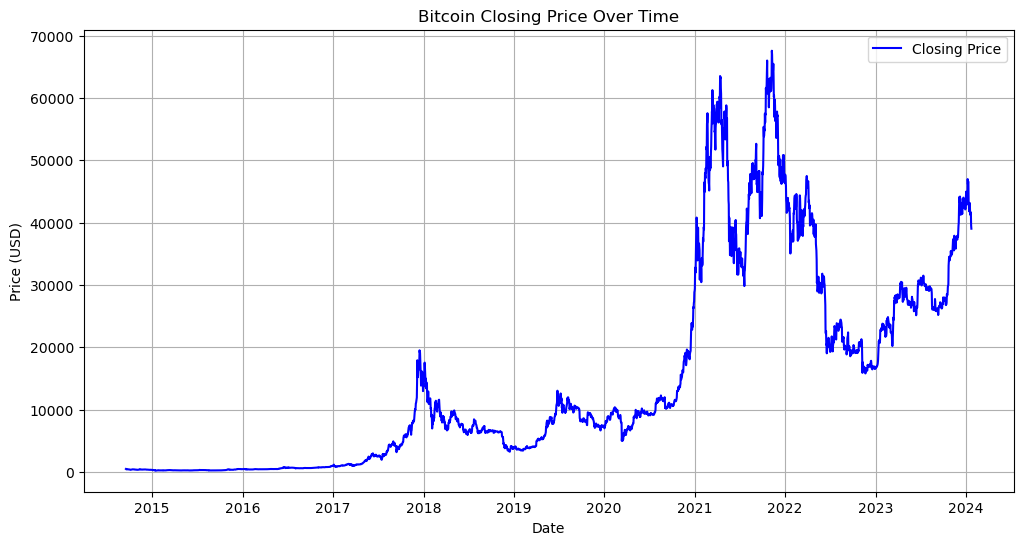

In [49]:
# Convert the 'Date' column to datetime for better plotting (make it easier to work with time series data)
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
# Plotting the closing price of Bitcoin
plt.figure(figsize=(12,6))
plt.plot(bitcoin_data['Date'], bitcoin_data['Close'], label='Closing Price', color='b')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Selecting the 'Close' price for prediction and normalizing the data
close_prices = bitcoin_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [30]:
# Function to create a dataset for LSTM
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [31]:
# Splitting the dataset into training and testing sets (training (80%) and testing (20%) sets.)
train_size = int(len(scaled_close_prices) * 0.80)
test_size = len(scaled_close_prices) - train_size
train, test = scaled_close_prices[0:train_size,:], scaled_close_prices[train_size:len(scaled_close_prices),:]

In [32]:
# Creating the training and testing data
look_back = 60
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [33]:
# Reshaping input to be [samples, time steps, features] into a format suitable for the LSTM network.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [35]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Model summary
model.summary()

# Training the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2671/2671 [=====

In [37]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual price
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_close_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_close_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_close_prices) - 1, :] = test_predict

20/20 [==============================] - 1s 28ms/step
Train RMSE:  18480.82683182574
Test RMSE:  25892.423721634346


In [50]:
from sklearn.metrics import r2_score

# Prepare true prices (Y) for comparison
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

# Calculate R² Score
train_r2 = r2_score(Y_train_inv[0], train_predict[:,0])
test_r2 = r2_score(Y_test_inv[0], test_predict[:,0])

# Print the R² scores
print("Train R²: ", train_r2)
print("Test R²: ", test_r2)

Train R²:  0.9826278374252122
Test R²:  0.9245055434124971


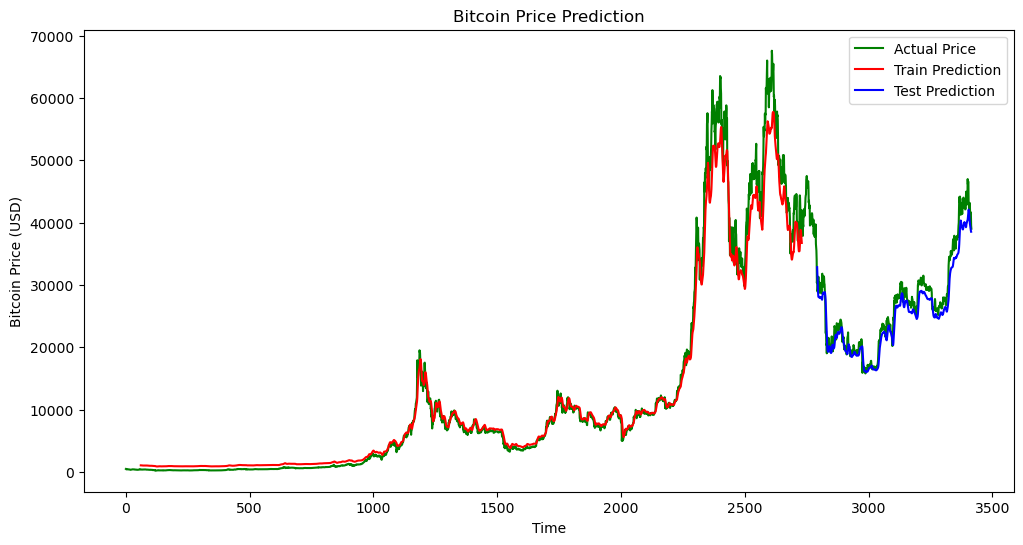

In [39]:
# Plot baseline and predictions
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(scaled_close_prices), label='Actual Price', color='g')
plt.plot(trainPredictPlot, label='Train Prediction', color='r')
plt.plot(testPredictPlot, label='Test Prediction', color='b')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

In [41]:
# Creating a DataFrame for a few test data points
comparison_df = pd.DataFrame({
    'Actual Price': scaler.inverse_transform(test)[look_back:look_back + 10].flatten(),
    'Predicted Price': test_predict[:10].flatten()
})

# Display the DataFrame
comparison_df

,Actual Price,Predicted Price
0,31022.906250,32840.484375
1,28936.355469,31719.396484
2,29047.751953,30491.548828
3,29283.103516,29401.771484
4,30101.265625,28568.640625
5,31305.113281,28095.021484
6,29862.917969,28034.349609
7,30425.857422,28008.906250
8,28720.271484,28087.072266
9,30314.333984,27987.242188


In [ ]:
 #I have set look_back to 60, which means the model uses the previous 60 days' closing prices to predict the price for the next day.